# Unauthorized Colonies Data De-Duplication (part 2)

## Goal: Merge de-deduplicated unauthorized colonies with missing unauthorized colonies found by Shubhada and find/remove any duplicate polygons

* Import all Shapefiles **[DONE]**
* Merge all Shapefiles and harmonize all columns
* Check that there are no duplicate rows **[DONE]**
* Set Index as Column  **[DONE]**
* Identify which attribute has multiple labels **[DONE]**
* Find the subset of Map Numbers that have multiple polygons for them **[DONE]**
* Generate PDF URLs from HTML file **[DONE]**
    * Extract URL segments via regex
    * Create URLs
    * Associate each map number to PDF URL
* Extract centroids from all PDF files **[DONE]**
    * Store centroids in a data structure associated with map number
    * This PDF centroid can be used in both algorithms below.
* Algorithm: Distance from PDF centroid to Polygon Centroid
    * Extract all PDF URL's from DDA website source (use combination of map no and registration number to figure out precise URL)
    * Apply PDF bounds algorithm to this
* Generate random list of 29 (5%) of map numbers to check for. This needs to be written to a text file for Anya. 
* Complete and save

In [89]:
# Import necessary modules
import pickle
import re
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import box, Polygon, MultiPolygon, LineString, MultiLineString 
from shapely.ops import polygonize, unary_union
from pyproj import CRS
import rasterio

import uac_utils

In [242]:
# Reload uac_utils when it gets updated
importlib.reload(uac_utils)

<module 'uac_utils' from "C:\\Users\\bwbel\\Google Drive\\slum_project\\UAC's Data Deduplication\\uac_utils.py">

In [91]:
%matplotlib inline

## Import UAC Shapefiles

In [92]:
uac_deduplicated = gpd.read_file(filename="uac_deduplicated.shp")

In [93]:
uac_missing1 = gpd.read_file(filename="Missing1_UAC.shp")

In [94]:
uac_missing2 = gpd.read_file(filename="Missing2_UAC.shp")

In [95]:
uac_deduplicated.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [96]:
uac_missing1.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 72°E to 78°E - by country
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [97]:
uac_missing2.crs

<Projected CRS: EPSG:32643>
Name: WGS 84 / UTM zone 43N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - N hemisphere - 72°E to 78°E - by country
- bounds: (72.0, 0.0, 78.0, 84.0)
Coordinate Operation:
- name: UTM zone 43N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Merge all Shapefiles and harmonize all columns

In [98]:
# See first couple of rows of uac_deduplicated
uac_deduplicated.head(2)

,OBJECTID,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,layer,path,index,geometry
0,1,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,0,"POLYGON ((8568698.722 3350778.289, 8568688.910..."
1,2,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,1to600,/home/hb/Documents/USO/Spatial_Index_Project/U...,1,"POLYGON ((8580894.912 3343225.741, 8580905.114..."


In [99]:
# See first couple of rows of uac_missing1
uac_missing1.head(2)

,OBJECTID,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,LAYER,PATH,INDEX,geometry
0,265,697,1198,"1198_HARIJAN BASTI, NEW ROHATAK ROAD",D:\UC Downloads\a-Missing Files\697_1198.pdf,None,None,0,"POLYGON ((712532.173 3172816.979, 712557.030 3..."
1,266,696,1094,1094_ANAND PARBHAT COLONY,D:\UC Downloads\a-Missing Files\696_1094.pdf,None,None,0,"POLYGON ((712769.831 3172131.192, 712773.227 3..."


In [100]:
# See first couple of rows of uac_missing2
uac_missing2.head(2)

,OBJECTID,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,LAYER,PATH,INDEX,geometry
0,0,0,509,509_MOONGA NAGAR,C:\Users\shubh\Desktop\Missing pdf downloads\1...,None,None,0,"POLYGON ((721307.428 3177864.962, 721309.097 3..."
1,0,0,1552,"1552_G-2,SANGAM VIHAR GALI NO 18",C:\Users\shubh\Desktop\Missing pdf downloads\1...,None,None,0,"POLYGON ((719878.107 3154528.633, 719869.967 3..."


In [101]:
# See list of uac_missing2 columns
uac_missing2.columns

Index(['OBJECTID', 'MAP_NO', 'REGISTRATI', 'IMG_NM_IND', 'FME_DATASE', 'LAYER',
       'PATH', 'INDEX', 'geometry'],
      dtype='object')

In [102]:
# Set common columns to use from all 3 shapefiles
common_columns = ['MAP_NO', 'REGISTRATI', 'IMG_NM_IND', 'FME_DATASE', 'geometry']

In [103]:
# Set each GeoDataFrame to only have common columns
uac_deduplicated = uac_deduplicated[common_columns]
uac_missing1 = uac_missing1[common_columns]
uac_missing2 = uac_missing2[common_columns]

In [104]:
# Create GeoDataFrame uac_merged that concatenates all 3 shapefiles above,
# designating CRS as EPSG 3857 and geometry field as "geometry" column
uac_merged = gpd.GeoDataFrame(pd.concat([uac_deduplicated, uac_missing1, uac_missing2], ignore_index=True),
                 crs = CRS.from_epsg(3857).to_wkt(), geometry="geometry")

In [105]:
# Check length of uac_merged
len(uac_merged)

2387

In [106]:
uac_merged.tail(20)

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry
2367,920,879,None,D:\UC Downloads\a-Missing Files\920_879.pdf,"POLYGON ((701524.344 3171064.228, 701593.686 3..."
2368,920,879,None,D:\UC Downloads\a-Missing Files\920_879.pdf,"POLYGON ((701877.381 3170651.421, 701878.136 3..."
2369,1433,201,None,D:\UC Downloads\a-Missing Files\1433_201.pdf,"POLYGON ((698948.151 3174291.857, 698990.757 3..."
2370,1294,133,692_GOURI SHANKAR ENCLAVE,D:\UC Downloads\a-Missing Files\1294_133.pdf,"POLYGON ((699307.403 3175151.958, 699399.435 3..."
2371,1435,861,None,D:\UC Downloads\a-Missing Files\1435_861.pdf,"POLYGON ((699986.214 3174984.629, 700026.937 3..."
2372,1438,4,None,D:\UC Downloads\a-Missing Files\1438_4.pdf,"POLYGON ((697900.763 3170042.314, 697899.032 3..."
2373,1431,178,None,D:\UC Downloads\a-Missing Files\1431_178.pdf,"POLYGON ((697948.940 3174955.044, 697936.435 3..."
2374,1436,67,None,D:\UC Downloads\a-Missing Files\1436_67.pdf,"POLYGON ((699233.905 3175343.388, 699234.275 3..."
2375,1441,762,None,D:\UC Downloads\a-Missing Files\1441_762.pdf,"POLYGON ((701177.850 3173600.023, 701159.748 3..."
2376,1439,1531,None,D:\UC Downloads\a-Missing Files\1439_1531.pdf,"POLYGON ((699223.833 3171271.948, 699223.244 3..."


In [107]:
uac_merged.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Check that there are no duplicate rows

In [108]:
# Check for duplicate rows
uac_utils.gdf_has_duplicate_rows(uac_merged)

True

In [109]:
# Remove all duplicate rows
uac_merged = uac_merged.drop_duplicates()

In [110]:
len(uac_merged)

1754

In [111]:
# Check for duplicate rows
uac_utils.gdf_has_duplicate_rows(uac_merged)

False

## Set Index as a Column

In [112]:
uac_merged = uac_utils.create_index_column(uac_merged)

In [113]:
uac_merged.head(2)

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
0,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1


## Confirm all Geometries are (Multi)Polygons

In [114]:
# Note, there is a row where geometry=None
uac_utils.all_polygon_geometries(uac_merged)

TypeError: argument of type 'NoneType' is not iterable

In [115]:
# Create copy of uac_merged
uac_merged_copy = uac_merged.copy()
uac_merged_copy.head(2)

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
0,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1


In [120]:
# Find index of row where geometry is not a Polygon
for idx, row in uac_merged_copy.iterrows():
    if "Polygon" not in str(type(row['geometry'])):
        print('Index', row['index'], 'is not a Polygon')
        print('Its geometry is', type(row['geometry']))

Index 1869 is not a Polygon
Its geometry is <class 'NoneType'>


In [121]:
# Index 1869 has no geometry
uac_merged[uac_merged['index'] == 1869]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
1869,1331,113-B,None,D:\UC Downloads\a-Missing Files\1331_113-B.pdf,None,1869


In [123]:
# Remove row 1869
uac_merged = uac_merged.drop(index=1869)

In [126]:
# We can see that row 1869 is now removed
uac_merged[uac_merged['index']==1869]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index


In [127]:
# All Polygon Geometries are there!
uac_utils.all_polygon_geometries(uac_merged)

True

## Identify which attribute(s) has/have multiple labels

In [128]:
map_registration_dict = uac_utils.create_map_registration_dict(uac_merged)

In [129]:
# Show first 5
list(map_registration_dict.items())[:5]

[(520, {'570'}),
 (509, {'888'}),
 (516, {'658'}),
 (503, {'200'}),
 (504, {'1194'})]

Let's write some code to see if each map number has one and only one registration number

In [130]:
# Check if number of registration numbers for each Map No is always 1
for key, val in map_registration_dict.items():
    if len(val) != 1:
        print(key, val)

1482 {'123', '123ELD'}
1500 {'969', '969A'}
1484 {'531', '531B'}
1481 {'4ELD', '4'}
1480 {'95ELD', '95'}
1457 {'945', '945B'}
682 {'660-B', '660B'}
1533 {'491A', '491'}
1507 {'1072a', '1072A'}
0 {'1460', '1552', '1108', '1022', '509', '127', '16'}


In [169]:
uac_merged[uac_merged['MAP_NO']==0]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
2380,0,509,509_MOONGA NAGAR,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((721307.428 3177864.962, 721309.097 3...",2380
2381,0,1552,"1552_G-2,SANGAM VIHAR GALI NO 18",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((719878.107 3154528.633, 719869.967 3...",2381
2382,0,1460,"1460_NEW T BLOCK, UTTAM NAGAR NEW DELHI-59",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((700488.839 3166838.612, 700491.088 3...",2382
2383,0,16,16_SHASHTRI PARK EXT,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((720406.762 3173763.997, 720407.012 3...",2383
2384,0,1108,1108_ADAESH NAGAR JEEVAN PARK,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((702471.983 3166965.449, 702470.551 3...",2384
2385,0,1022,None,C:\Users\shubh\Desktop\Missing pdf downloads\4...,"POLYGON ((714477.145 3153632.769, 714468.179 3...",2385
2386,0,127,692_GOURI SHANKAR ENCLAVE,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((699307.403 3175151.958, 699399.435 3...",2386


In [170]:
uac_missing_maps = uac_merged[uac_merged['MAP_NO']==0]

In [171]:
uac_missing_maps

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
2380,0,509,509_MOONGA NAGAR,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((721307.428 3177864.962, 721309.097 3...",2380
2381,0,1552,"1552_G-2,SANGAM VIHAR GALI NO 18",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((719878.107 3154528.633, 719869.967 3...",2381
2382,0,1460,"1460_NEW T BLOCK, UTTAM NAGAR NEW DELHI-59",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((700488.839 3166838.612, 700491.088 3...",2382
2383,0,16,16_SHASHTRI PARK EXT,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((720406.762 3173763.997, 720407.012 3...",2383
2384,0,1108,1108_ADAESH NAGAR JEEVAN PARK,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((702471.983 3166965.449, 702470.551 3...",2384
2385,0,1022,None,C:\Users\shubh\Desktop\Missing pdf downloads\4...,"POLYGON ((714477.145 3153632.769, 714468.179 3...",2385
2386,0,127,692_GOURI SHANKAR ENCLAVE,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((699307.403 3175151.958, 699399.435 3...",2386


In [172]:
uac_merged_without_missing_maps = uac_merged.drop(index=[2380, 2381, 2382, 2383, 2384, 2385, 2386])

In [173]:
uac_merged_without_missing_maps[uac_merged_without_missing_maps['MAP_NO'] == 0]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index


In [232]:
map_registration_dict = uac_utils.create_map_registration_dict(uac_merged_without_missing_maps)

In [233]:
# Check if number of registration numbers for each Map No is always 1
for key, val in map_registration_dict.items():
    if len(val) != 1:
        print(key, val)

In [222]:
uac_merged_without_missing_maps[uac_merged_without_missing_maps['MAP_NO']==1533]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
1985,1533,491,None,D:\UC Downloads\a-Missing Files\1533_491_A.pdf,"POLYGON ((697843.260 3166044.976, 697838.795 3...",1985
2011,1533,491,None,D:\UC Downloads\a-Missing Files\1533_491_A.pdf,"POLYGON ((698180.133 3166469.408, 698248.445 3...",2011
2038,1533,491,None,D:\UC Downloads\a-Missing Files\1533_491_A.pdf,"POLYGON ((698312.513 3166042.675, 698516.556 3...",2038
2065,1533,491,None,D:\UC Downloads\a-Missing Files\1533_491_A.pdf,"POLYGON ((697770.819 3166101.842, 697777.851 3...",2065


In [223]:
# Find index number and then change single value like this
uac_merged_without_missing_maps.loc[1985, 'REGISTRATI'] = 491
uac_merged_without_missing_maps.loc[2011, 'REGISTRATI'] = 491
uac_merged_without_missing_maps.loc[2038, 'REGISTRATI'] = 491
uac_merged_without_missing_maps.loc[2065, 'REGISTRATI'] = 491

## Two GeoDataFrames for processing

In [234]:
# All UAC's with map numbers
uac_merged_without_missing_maps.head(2)

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
0,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1


In [235]:
uac_missing_maps.head(2)

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
2380,0,509,509_MOONGA NAGAR,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((721307.428 3177864.962, 721309.097 3...",2380
2381,0,1552,"1552_G-2,SANGAM VIHAR GALI NO 18",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((719878.107 3154528.633, 719869.967 3...",2381


In [236]:
# Save files to disk
uac_merged_without_missing_maps.to_file("uac_merged_without_missing_maps.shp")
uac_missing_maps.to_file("uac_missing_maps.shp")

In [239]:
# Confirming this GDF has no maps with MAP_NO=0
uac_merged_without_missing_maps[uac_merged_without_missing_maps['MAP_NO'] == 0]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index


In [241]:
# Confirming this GDF has maps with MAP_NO=0
uac_missing_maps[uac_missing_maps['MAP_NO'] == 0]

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
2380,0,509,509_MOONGA NAGAR,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((721307.428 3177864.962, 721309.097 3...",2380
2381,0,1552,"1552_G-2,SANGAM VIHAR GALI NO 18",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((719878.107 3154528.633, 719869.967 3...",2381
2382,0,1460,"1460_NEW T BLOCK, UTTAM NAGAR NEW DELHI-59",C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((700488.839 3166838.612, 700491.088 3...",2382
2383,0,16,16_SHASHTRI PARK EXT,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((720406.762 3173763.997, 720407.012 3...",2383
2384,0,1108,1108_ADAESH NAGAR JEEVAN PARK,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((702471.983 3166965.449, 702470.551 3...",2384
2385,0,1022,None,C:\Users\shubh\Desktop\Missing pdf downloads\4...,"POLYGON ((714477.145 3153632.769, 714468.179 3...",2385
2386,0,127,692_GOURI SHANKAR ENCLAVE,C:\Users\shubh\Desktop\Missing pdf downloads\1...,"POLYGON ((699307.403 3175151.958, 699399.435 3...",2386


## Find subset of Map Numbers that are Duplicated

In [237]:
duplicate_map_numbers = uac_utils.maps_numbers_with_duplicate_polygons(uac_merged_without_missing_maps)

Number of map numbers that are duplicated: 108


## Generate PDF URLs from HTML file
* Extract URL segments via regex
* Create URLs
* Associate each map number to PDF URL

In [243]:
map_url_dict = uac_utils.generate_map_URLs(duplicate_map_numbers)

In [244]:
# Show first 5 entries
list(map_url_dict.items())[:5]

[(250, 'https://dda.org.in//tendernotices_docs/27112019/MAP%20250_277.pdf'),
 (1328, 'https://dda.org.in//tendernotices_docs/27112019/1328_1154.pdf'),
 (1324, 'https://dda.org.in//tendernotices_docs/27112019/1324_696.pdf'),
 (1330, 'https://dda.org.in//tendernotices_docs/27112019/1330_70_B.pdf'),
 (1331, 'https://dda.org.in//tendernotices_docs/27112019/1331_113-B.pdf')]

In [245]:
map_url_dict

{250: 'https://dda.org.in//tendernotices_docs/27112019/MAP%20250_277.pdf',
 1328: 'https://dda.org.in//tendernotices_docs/27112019/1328_1154.pdf',
 1324: 'https://dda.org.in//tendernotices_docs/27112019/1324_696.pdf',
 1330: 'https://dda.org.in//tendernotices_docs/27112019/1330_70_B.pdf',
 1331: 'https://dda.org.in//tendernotices_docs/27112019/1331_113-B.pdf',
 1329: 'https://dda.org.in//tendernotices_docs/27112019/1329_845-A.pdf',
 1325: 'https://dda.org.in//tendernotices_docs/27112019/1325_287.pdf',
 634: 'https://dda.org.in//tendernotices_docs/27112019/634_36_LOP.pdf',
 651: 'https://dda.org.in//tendernotices_docs/27112019/651_937.pdf',
 649: 'https://dda.org.in//tendernotices_docs/27112019/649_447.pdf',
 672: 'https://dda.org.in//tendernotices_docs/27112019/672_1234.pdf',
 693: 'https://dda.org.in//tendernotices_docs/27112019/693_1585.pdf',
 682: 'https://dda.org.in//tendernotices_docs/27112019/682_660_B.pdf',
 662: 'https://dda.org.in//tendernotices_docs/27112019/662_716.pdf',
 66

In [247]:
map_url_dict[4] = r"https://dda.org.in/tendernotices_docs/27112019/04_157.pdf"

In [248]:
map_url_dict

{250: 'https://dda.org.in//tendernotices_docs/27112019/MAP%20250_277.pdf',
 1328: 'https://dda.org.in//tendernotices_docs/27112019/1328_1154.pdf',
 1324: 'https://dda.org.in//tendernotices_docs/27112019/1324_696.pdf',
 1330: 'https://dda.org.in//tendernotices_docs/27112019/1330_70_B.pdf',
 1331: 'https://dda.org.in//tendernotices_docs/27112019/1331_113-B.pdf',
 1329: 'https://dda.org.in//tendernotices_docs/27112019/1329_845-A.pdf',
 1325: 'https://dda.org.in//tendernotices_docs/27112019/1325_287.pdf',
 634: 'https://dda.org.in//tendernotices_docs/27112019/634_36_LOP.pdf',
 651: 'https://dda.org.in//tendernotices_docs/27112019/651_937.pdf',
 649: 'https://dda.org.in//tendernotices_docs/27112019/649_447.pdf',
 672: 'https://dda.org.in//tendernotices_docs/27112019/672_1234.pdf',
 693: 'https://dda.org.in//tendernotices_docs/27112019/693_1585.pdf',
 682: 'https://dda.org.in//tendernotices_docs/27112019/682_660_B.pdf',
 662: 'https://dda.org.in//tendernotices_docs/27112019/662_716.pdf',
 66

# Extract centroids from all PDF files
* Store centroids in a data structure associated with map number
* This PDF centroid can be used in both algorithms below.

In [249]:
map_centroid_crs_dict = uac_utils.generate_map_centroid_crs(map_url_dict)

In [250]:
list(map_centroid_crs_dict.items())[:5]

[(250,
  {'centroid': <shapely.geometry.point.Point at 0x26424b2a048>,
   'crs': CRS.from_epsg(32643)}),
 (1328,
  {'centroid': <shapely.geometry.point.Point at 0x26421bb7a88>,
   'crs': CRS.from_epsg(32643)}),
 (1324,
  {'centroid': <shapely.geometry.point.Point at 0x26424b2a5c8>,
   'crs': CRS.from_epsg(32643)}),
 (1330,
  {'centroid': <shapely.geometry.point.Point at 0x26424b2afc8>,
   'crs': CRS.from_epsg(32643)}),
 (1331,
  {'centroid': <shapely.geometry.point.Point at 0x26424b2a8c8>,
   'crs': CRS.from_epsg(32643)})]

In [251]:
# Write map_centroid_crs dictionary to disk:

with open('map_centroid_crs_dict_uac_without_missing_maps.data', 'wb') as fp:
    pickle.dump(map_centroid_crs_dict, fp)

In [ ]:
# Read in map_centroid_crs dictionary from disk:
with open('map_centroid_crs_dict.data', 'rb') as fp:
    map_centroid_crs_from_file = pickle.load(fp)

## TODO: Create Function to Randomly Generate 29 Maps to Check

## Algorithm 1: Distance from PDF centroid to Polygon centroid 

In [ ]:
#uac_utils.identify_polygon_from_map_no_and_pdf(uac_merged, 733, map_centroid_crs_dict)

In [252]:
# Create new dictionary to store results of which
# polygons to keep vs. delete based on algorithm 1
polygon_map_matching1 = dict()

In [253]:
for map_number in duplicate_map_numbers:
    polygon_map_result = uac_utils.identify_polygon_from_map_no_and_pdf(uac_merged_without_missing_maps, 
                                                                        map_number, 
                                                                        map_centroid_crs_dict)
    polygon_map_matching1[map_number] = polygon_map_result 

In [258]:
list(polygon_map_matching1.items())[:-5]

[(250, {'delete': [], 'keep': 367}),
 (1328, {'delete': [1866, 1867, 1868], 'keep': 1888}),
 (1324,
  {'delete': [1870, 1871, 1872, 1873, 1890, 1891, 1892, 1893, 1894],
   'keep': 1889}),
 (1330, {'delete': [1874, 1875, 1876], 'keep': 1877}),
 (1331, {'delete': [1878, 1879, 1880, 1881, 1883, 1884, 1885], 'keep': 1882}),
 (1329, {'delete': [1887], 'keep': 1886}),
 (1325, {'delete': [1895], 'keep': 1896}),
 (634, {'delete': [1901], 'keep': 1898}),
 (651, {'delete': [1916, 1926, 1941, 1979, 1983], 'keep': 1906}),
 (649, {'delete': [1919, 1959], 'keep': 1922}),
 (672, {'delete': [1927, 1967], 'keep': 1907}),
 (693, {'delete': [1929], 'keep': 1912}),
 (682, {'delete': [1932, 1938, 1940], 'keep': 1905}),
 (662, {'delete': [1943], 'keep': 1935}),
 (664, {'delete': [1946, 1981], 'keep': 1902}),
 (650, {'delete': [1921], 'keep': 1947}),
 (691, {'delete': [1950, 1980], 'keep': 1933}),
 (671, {'delete': [1954, 1972, 1973, 1975, 1976, 1978], 'keep': 1909}),
 (673, {'delete': [1911], 'keep': 1955})

In [255]:
# Write polygon_map_matching1 dictionary to disk:

with open('polygon_map_matching_uac_without_missing_maps.data', 'wb') as fp:
    pickle.dump(polygon_map_matching1, fp)

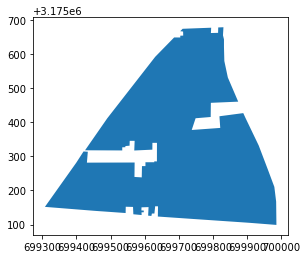

In [269]:
# To visualize map with specific index
uac_merged_without_missing_maps[uac_merged_without_missing_maps['index']==2327].plot()

### Checking random 5% of duplicate maps
* 733: Correct! (https://dda.org.in/tendernotices_docs/27112019/733_291.pdf)
* 497: Correct! (https://dda.org.in/tendernotices_docs/27112019/497_676.pdf)
* 348: Correct! (https://dda.org.in/tendernotices_docs/27112019/348_1378.pdf)
* 1436: Correct! (https://dda.org.in/tendernotices_docs/27112019/1436_67.pdf)
* 1572: (https://dda.org.in/tendernotices_docs/27112019/1572_1331.pdf)
* 865: Correct! https://dda.org.in/tendernotices_docs/27112019/865_1354B.pdf
* 974: Correct! (https://dda.org.in/tendernotices_docs/27112019/974_1175_A.pdf)
* 738: Correct! (https://dda.org.in/tendernotices_docs/27112019/738_806_A.pdf)
* 990: Correct!
* 224: Correct!

## Checking that no index to be deleted is in keep list (and vice versa)

In [270]:
delete_list = []
keep_list = []

for key, val in polygon_map_matching1.items():
    delete_list.extend(val['delete'])
    keep_list.append(val['keep'])

In [271]:
[keep_num for keep_num in keep_list if keep_num in delete_list]

[]

In [272]:
[delete_num for delete_num in delete_list if delete_num in keep_list]

[]

In [273]:
# Visualize first 5 of delete_list
delete_list[:5]

[1866, 1867, 1868, 1870, 1871]

## Delete rows

In [274]:
# Created GeoDataFrame removing all rows with an index
# in delete_list
uac_merged_without_missing_maps = uac_merged_without_missing_maps.drop(index=delete_list)

In [275]:
# Check length of uac_merged_final
len(uac_merged_without_missing_maps)

1480

## Merge Files

In [278]:
# Make copy of uac_merged
uac_merged_final = gpd.GeoDataFrame(pd.concat([uac_merged_without_missing_maps, uac_missing_maps]),
                                    crs=CRS.from_epsg(3857).to_wkt(), geometry="geometry")

In [279]:
uac_merged_final.head()

,MAP_NO,REGISTRATI,IMG_NM_IND,FME_DATASE,geometry,index
0,520,570,SHIV COLNY KATEWADA,D:\UC Downloads\UC_501-600-Done\520_570.pdf,"POLYGON ((8568698.722 3350778.289, 8568688.910...",0
1,509,888,KRISHNA COLONY,D:\UC Downloads\UC_501-600-Done\509_888.pdf,"POLYGON ((8580894.912 3343225.741, 8580905.114...",1
2,516,658,INDRAJ COLONY,D:\UC Downloads\UC_501-600-Done\516_658.pdf,"POLYGON ((8574843.534 3349736.689, 8574924.630...",2
3,503,200,"NEW COLONY SANNOTH,NARELA",D:\UC Downloads\UC_501-600-Done\503_200.pdf,"POLYGON ((8578433.979 3352949.941, 8578436.107...",3
4,504,1194,VISHAL ENCLAVE,D:\UC Downloads\UC_501-600-Done\504_1194.pdf,"POLYGON ((8579255.777 3353628.687, 8579180.169...",4


In [280]:
len(uac_merged_final)

1487

In [281]:
uac_merged_final.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: unnamed
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Save uac_merged_final file

In [282]:
uac_merged_final.to_file("uac_final_deduplicated.shp")

## Random checks for Anya

In [ ]:
import random
random_ints = random.sample(range(565), 29)
random_ints